In [80]:
from matplotlib import pyplot as plt
import os
import numpy as np
import json
from sklearn.linear_model import LinearRegression
import pandas as pd


file_dir = "/data03/sunyi/time_constrained_cot/outputs/2_6"
latency_path = "/home/sunyi/CoT/Time-Constrained-CoT/latency/0210"
model_list = [
    "Qwen/QwQ-32B-Preview",
    # "Skywork/Skywork-o1-Open-Llama-3.1-8B", 
    # "PowerInfer/SmallThinker-3B-Preview",
    "NovaSky-AI/Sky-T1-32B-Preview",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    "Qwen/Qwen2.5-Math-1.5B-Instruct",
    "Qwen/Qwen2.5-Math-7B-Instruct",
    "mistralai/Mathstral-7B-v0.1",
    "Qwen/Qwen2.5-32B-Instruct",
    "Qwen/Qwen2.5-14B-Instruct",
    "Qwen/Qwen2.5-7B-Instruct",
    "Qwen/Qwen2.5-3B-Instruct",
    "Qwen/Qwen2.5-1.5B-Instruct",
    "mistralai/Mistral-Small-Instruct-2409",
    "mistralai/Mistral-Nemo-Instruct-2407",
    "mistralai/Ministral-8B-Instruct-2410",
    "google/gemma-2-27b-it",
    "google/gemma-2-9b-it",
    "google/gemma-2-2b-it",
    "microsoft/Phi-3-medium-128k-instruct",
    "microsoft/Phi-3-small-128k-instruct",
    "microsoft/Phi-3-mini-128k-instruct",
    "microsoft/Phi-3.5-mini-instruct",
    "microsoft/phi-4",
    "meta-llama/Llama-3.1-8B-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.2-1B-Instruct",
]

In [81]:
PROMP_LIST = [ "-aav", "-c2f", "-sbs", "-sbs-hard", "-sbs-budget-hard"]


MODEL_SERIES_MAP = {
    "Qwen/QwQ-32B-Preview": "qwen",
    "Qwen/Qwen2.5-32B-Instruct": "qwen",
    "Qwen/Qwen2.5-14B-Instruct": "qwen",
    "Qwen/Qwen2.5-7B-Instruct": "qwen",
    "Qwen/Qwen2.5-3B-Instruct": "qwen",
    "Qwen/Qwen2.5-1.5B-Instruct": "qwen",
    "Qwen/Qwen2.5-Math-1.5B-Instruct": "qwen-math",
    "Qwen/Qwen2.5-Math-7B-Instruct": "qwen-math",
    "internlm/internlm2_5-1_8b-chat": "internlm",
    "internlm/internlm2_5-7b-chat": "internlm",
    "internlm/internlm2_5-20b-chat": "internlm",
    "google/gemma-2-2b-it": "gemma",
    "google/gemma-2-9b-it": "gemma",
    "google/gemma-2-27b-it": "gemma",
    "mistralai/Mathstral-7B-v0.1": "mistral",
    "mistralai/Ministral-8B-Instruct-2410": "mistral",
    "mistralai/Mistral-Nemo-Instruct-2407": "mistral",
    "mistralai/Mistral-Small-Instruct-2409": "mistral",
    "microsoft/phi-4": "phi4",
    "microsoft/Phi-3-medium-128k-instruct": "phi3medium",
    "microsoft/Phi-3-small-128k-instruct": "phi3small",
    "microsoft/Phi-3.5-mini-instruct": "phi3mini",
    "microsoft/Phi-3-mini-128k-instruct": "phi3mini",
    "NovaSky-AI/Sky-T1-32B-Preview": "qwen",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B": "deepseek-r1-distill",
    "meta-llama/Llama-3.2-3B-Instruct": "llama",
    "meta-llama/Llama-3.2-1B-Instruct": "llama",
    "meta-llama/Llama-3.1-8B-Instruct": "llama"
}


MODEL_SERIES_PROMPT_TYPE_MAP = {
    "qwen": ["qwen" + prompt for prompt in PROMP_LIST],
    "qwen-math": ["qwen-math" + prompt for prompt in PROMP_LIST],
    "internlm": ["internlm"+prompt for prompt in PROMP_LIST],
    "mistral": ["mistral"+prompt for prompt in PROMP_LIST],
    "gemma": ["gemma"+prompt for prompt in PROMP_LIST],
    "phi3mini": ["phi3mini"+prompt for prompt in PROMP_LIST],
    "phi3small": ["phi3small"+prompt for prompt in PROMP_LIST],
    "phi3medium": ["phi3medium"+prompt for prompt in PROMP_LIST],
    "phi4": ["phi4"+prompt for prompt in PROMP_LIST],
    "deepseek-r1-distill": ["deepseek-r1-distill"+prompt for prompt in PROMP_LIST],
    "llama": ["llama"+prompt for prompt in PROMP_LIST]
}

In [82]:
def gen_budget_latency_list(budget, data_name, model, prompt_type):
    if budget == -1:
        return [-1]
    elif budget == 1:
        o1_like_models = [
            "Qwen/QwQ-32B-Preview", 
            "Skywork/Skywork-o1-Open-Llama-3.1-8B", 
            "PowerInfer/SmallThinker-3B-Preview",
            "NovaSky-AI/Sky-T1-32B-Preview", 
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
            "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
        ]
        if model in o1_like_models: # maybe should extend to longer sequence
            if data_name == "gsm8k":
                budget_list = []
                for i in range(25, 300, 25):
                    budget_list.append(i)
                for i in range(300, 600, 50):
                    budget_list.append(i)
                for i in range(600, 1201, 100):
                    budget_list.append(i)
            elif data_name in ["math", "math500"]:
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 2401, 100):
                    budget_list.append(i)
        else:    
            if data_name == "gsm8k":
                budget_list = []
                for i in range(25, 300, 25):
                    budget_list.append(i)
                for i in range(300, 601, 50):
                    budget_list.append(i)
            elif data_name in ["math", "math500"]:
                budget_list = []
                for i in range(25, 300, 25):
                    budget_list.append(i)
                for i in range(300, 600, 50):
                    budget_list.append(i)
                for i in range(600, 1201, 100):
                    budget_list.append(i)
    
        if "hard" not in prompt_type:
            budget_list = [budget + 25 for budget in budget_list]
        
        tokens = np.array([64, 128, 256, 512, 1024])
        file = model.split("/")[-1] + "_a800.csv"
        df = pd.read_csv(os.path.join(latency_path, file))
        latencies = df.iloc[1, 1:].values  # Extract latency values for the first row
        # Perform linear regression on the measured latency data
        linear_model = LinearRegression()
        tokens = tokens.reshape(-1, 1)
        linear_model.fit(tokens, latencies)
        print(f"File: {file} - Linear Fit: Slope = {linear_model.coef_[0]:.2f}, Intercept = {linear_model.intercept_:.2f}")
        print(f"File: {file} - R^2 Score: {linear_model.score(tokens, latencies):.2f}")
        # change budget_list into latency_list using the linear regression model
        budget_list = np.array(budget_list)
        budget_list = budget_list.reshape(-1, 1)
        latency_list = linear_model.predict(budget_list)
        budget_list = budget_list.reshape(1, -1)[0]
        latency_list = latency_list.reshape(1, -1)[0]

        if "hard" not in prompt_type:
            budget_list = [budget - 25 for budget in budget_list]
            
        return budget_list, latency_list

In [83]:
dataset = "gsm8k"
something = "_-1_seed0_t0.0_s0_e-1"

In [84]:
model_acc_dicts = {}
model_latency_dicts = {}

for model in model_list:
    model_acc_dict = {}
    model_latency_dict = {}

    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        budget_list, latency_list = gen_budget_latency_list(1, dataset, model, prompt_type)
        acc_list = []
        for budget in budget_list:
            file_name = "test_" + prompt_type + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path = os.path.join(file_dir, model, prompt_type, dataset, file_name)
            with open(file_path, "r") as f:
                acc_list.append(json.load(f)["acc"])
        model_acc_dict[prompt_type] = acc_list
        model_latency_dict[prompt_type] = latency_list
    model_acc_dicts[model] = model_acc_dict
    model_latency_dicts[model] = model_latency_dict

model_latency_dicts

File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.29
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.29
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.29
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.29
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.29
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: Sky-T1-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.30
File: Sky-T1-32B-Preview_a800.csv - R^2 Score: 1.00
File: Sky-T1-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.30
File: Sky-T1-32B-Preview_a800.csv - R^2 Score: 1.00
File: Sky-T1-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.30
File: Sky-T1-32B-Preview_a

{'Qwen/QwQ-32B-Preview': {'qwen-aav': array([ 2.39787402,  3.74170333,  5.08553264,  6.42936195,  7.77319127,
          9.11702058, 10.46084989, 11.80467921, 13.14850852, 14.49233783,
         15.83616715, 17.17999646, 19.86765508, 22.55531371, 25.24297234,
         27.93063096, 30.61828959, 33.30594821, 38.68126547, 44.05658272,
         49.43189997, 54.80721722, 60.18253447, 65.55785173]),
  'qwen-c2f': array([ 2.39787402,  3.74170333,  5.08553264,  6.42936195,  7.77319127,
          9.11702058, 10.46084989, 11.80467921, 13.14850852, 14.49233783,
         15.83616715, 17.17999646, 19.86765508, 22.55531371, 25.24297234,
         27.93063096, 30.61828959, 33.30594821, 38.68126547, 44.05658272,
         49.43189997, 54.80721722, 60.18253447, 65.55785173]),
  'qwen-sbs': array([ 2.39787402,  3.74170333,  5.08553264,  6.42936195,  7.77319127,
          9.11702058, 10.46084989, 11.80467921, 13.14850852, 14.49233783,
         15.83616715, 17.17999646, 19.86765508, 22.55531371, 25.24297234,


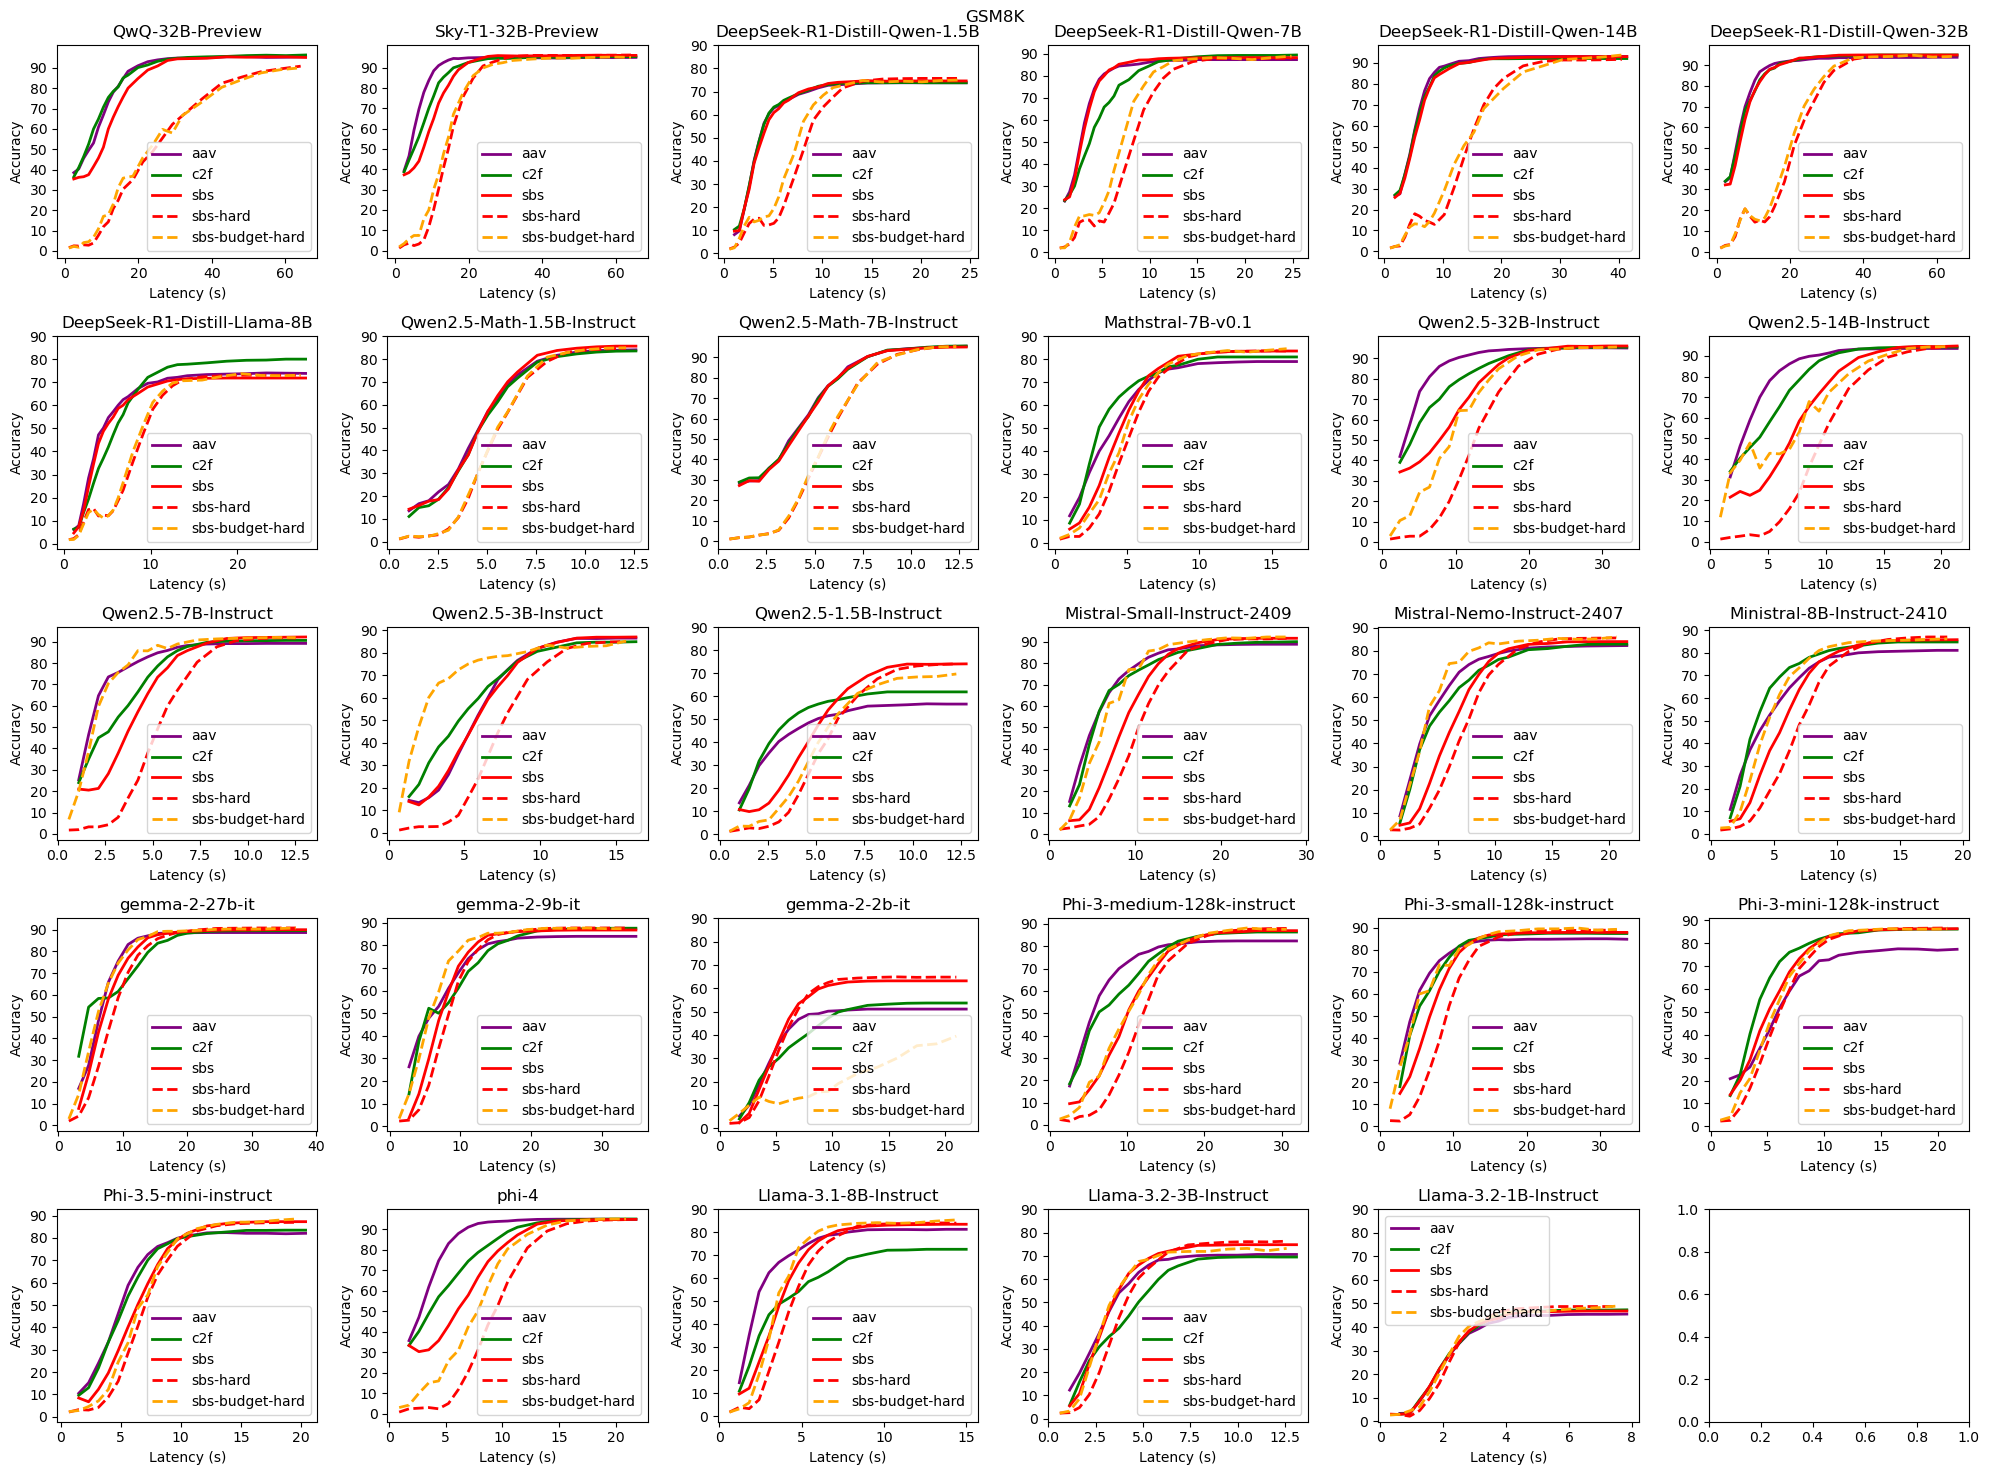

In [85]:
# Create a 2x3 subplot
fig, axs = plt.subplots(5, 6, figsize=(20, 15))
marker_size = 5  # Set the desired marker size
line_width = 2   # Set the desired line width

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot all lines first without labels
for index, model in enumerate(model_list):
    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        if "sbs-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][prompt_type], model_acc_dicts[model][prompt_type], linestyle='--', color="red", label="sbs-hard", linewidth=line_width)
        elif "sbs-budget-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][prompt_type], model_acc_dicts[model][prompt_type], linestyle='--', color="orange", label="sbs-budget-hard", linewidth=line_width)
        elif "direct-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="orange", label="direct-hard", linewidth=line_width)
        elif "quick-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="pink", label="quick-hard", linewidth=line_width)
        elif "c2f-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="green", label="c2f-hard", linewidth=line_width)
        elif "aav-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="purple", label="aav-hard", linewidth=line_width)
        elif "sbs" in prompt_type:
            axs[index].plot(model_latency_dicts[model][prompt_type], model_acc_dicts[model][prompt_type], linestyle='-', color="red", label="sbs", linewidth=line_width)
        elif "direct" in prompt_type:
            axs[index].plot(model_latency_dicts[model][prompt_type], model_acc_dicts[model][prompt_type], linestyle='-', color="orange", label="direct", linewidth=line_width)
        elif "quick" in prompt_type:
            axs[index].plot(model_latency_dicts[model][prompt_type], model_acc_dicts[model][prompt_type], linestyle='-', color="pink", label="quick", linewidth=line_width)
        elif "c2f" in prompt_type:
            axs[index].plot(model_latency_dicts[model][prompt_type], model_acc_dicts[model][prompt_type], linestyle='-', color="green", label="c2f", linewidth=line_width)
        # elif "kf" in prompt_type:
        #     axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="blue", label="kf", linewidth=line_width)
        elif "aav" in prompt_type:
            axs[index].plot(model_latency_dicts[model][prompt_type], model_acc_dicts[model][prompt_type], linestyle='-', color="purple", label="aav", linewidth=line_width)
        axs[index].set_xlabel("Latency (s)")
        axs[index].set_ylabel("Accuracy")
        axs[index].set_title(f"{model.split('/')[-1]}")
        axs[index].legend()
        
        # Set y-axis and x-axis ticks
        axs[index].set_yticks(range(0, 91, 10))  # Set y-axis interval to 10
        # axs[index].set_xticks(range(0, 551, 50))  # Set x-axis interval to 50

# set the title
plt.suptitle(f"{dataset}".upper())
# Adjust layout
plt.tight_layout()

In [86]:
dataset = "math500"
something = "_-1_seed0_t0.0_s0_e-1"

In [87]:
model_acc_dicts = {}
model_latency_dicts = {}

for model in model_list:
    model_acc_dict = {}

    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        budget_list, latency_list = gen_budget_latency_list(1, dataset, model, prompt_type)
        acc_list = []
        for budget in budget_list:
            file_name = "test_" + prompt_type + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path = os.path.join(file_dir, model, prompt_type, dataset, file_name)
            with open(file_path, "r") as f:
                acc_list.append(json.load(f)["acc"])
        model_acc_dict[prompt_type] = acc_list
    model_acc_dicts[model] = model_acc_dict
    model_latency_dicts[model] = latency_list

model_latency_dicts

File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.29
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.29
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.29
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.29
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.29
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: Sky-T1-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.30
File: Sky-T1-32B-Preview_a800.csv - R^2 Score: 1.00
File: Sky-T1-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.30
File: Sky-T1-32B-Preview_a800.csv - R^2 Score: 1.00
File: Sky-T1-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.30
File: Sky-T1-32B-Preview_a

File: Mistral-Small-Instruct-2409_a800.csv - Linear Fit: Slope = 0.05, Intercept = 0.09
File: Mistral-Small-Instruct-2409_a800.csv - R^2 Score: 1.00
File: Mistral-Small-Instruct-2409_a800.csv - Linear Fit: Slope = 0.05, Intercept = 0.09
File: Mistral-Small-Instruct-2409_a800.csv - R^2 Score: 1.00
File: Mistral-Small-Instruct-2409_a800.csv - Linear Fit: Slope = 0.05, Intercept = 0.09
File: Mistral-Small-Instruct-2409_a800.csv - R^2 Score: 1.00
File: Mistral-Nemo-Instruct-2407_a800.csv - Linear Fit: Slope = 0.03, Intercept = -0.01
File: Mistral-Nemo-Instruct-2407_a800.csv - R^2 Score: 1.00
File: Mistral-Nemo-Instruct-2407_a800.csv - Linear Fit: Slope = 0.03, Intercept = -0.01
File: Mistral-Nemo-Instruct-2407_a800.csv - R^2 Score: 1.00
File: Mistral-Nemo-Instruct-2407_a800.csv - Linear Fit: Slope = 0.03, Intercept = -0.01
File: Mistral-Nemo-Instruct-2407_a800.csv - R^2 Score: 1.00
File: Mistral-Nemo-Instruct-2407_a800.csv - Linear Fit: Slope = 0.03, Intercept = -0.01
File: Mistral-Nemo-In

{'Qwen/QwQ-32B-Preview': array([  1.0540447 ,   2.39787402,   3.74170333,   5.08553264,
          6.42936195,   7.77319127,   9.11702058,  10.46084989,
         11.80467921,  13.14850852,  14.49233783,  15.83616715,
         17.17999646,  18.52382577,  19.86765508,  21.2114844 ,
         22.55531371,  23.89914302,  25.24297234,  26.58680165,
         27.93063096,  29.27446028,  30.61828959,  31.9621189 ,
         37.33743615,  42.71275341,  48.08807066,  53.46338791,
         58.83870516,  64.21402241,  69.58933966,  74.96465692,
         80.33997417,  85.71529142,  91.09060867,  96.46592592,
        101.84124318, 107.21656043, 112.59187768, 117.96719493,
        123.34251218, 128.71782944]),
 'NovaSky-AI/Sky-T1-32B-Preview': array([  1.03828336,   2.38065473,   3.7230261 ,   5.06539747,
          6.40776885,   7.75014022,   9.09251159,  10.43488296,
         11.77725433,  13.1196257 ,  14.46199708,  15.80436845,
         17.14673982,  18.48911119,  19.83148256,  21.17385393,
         

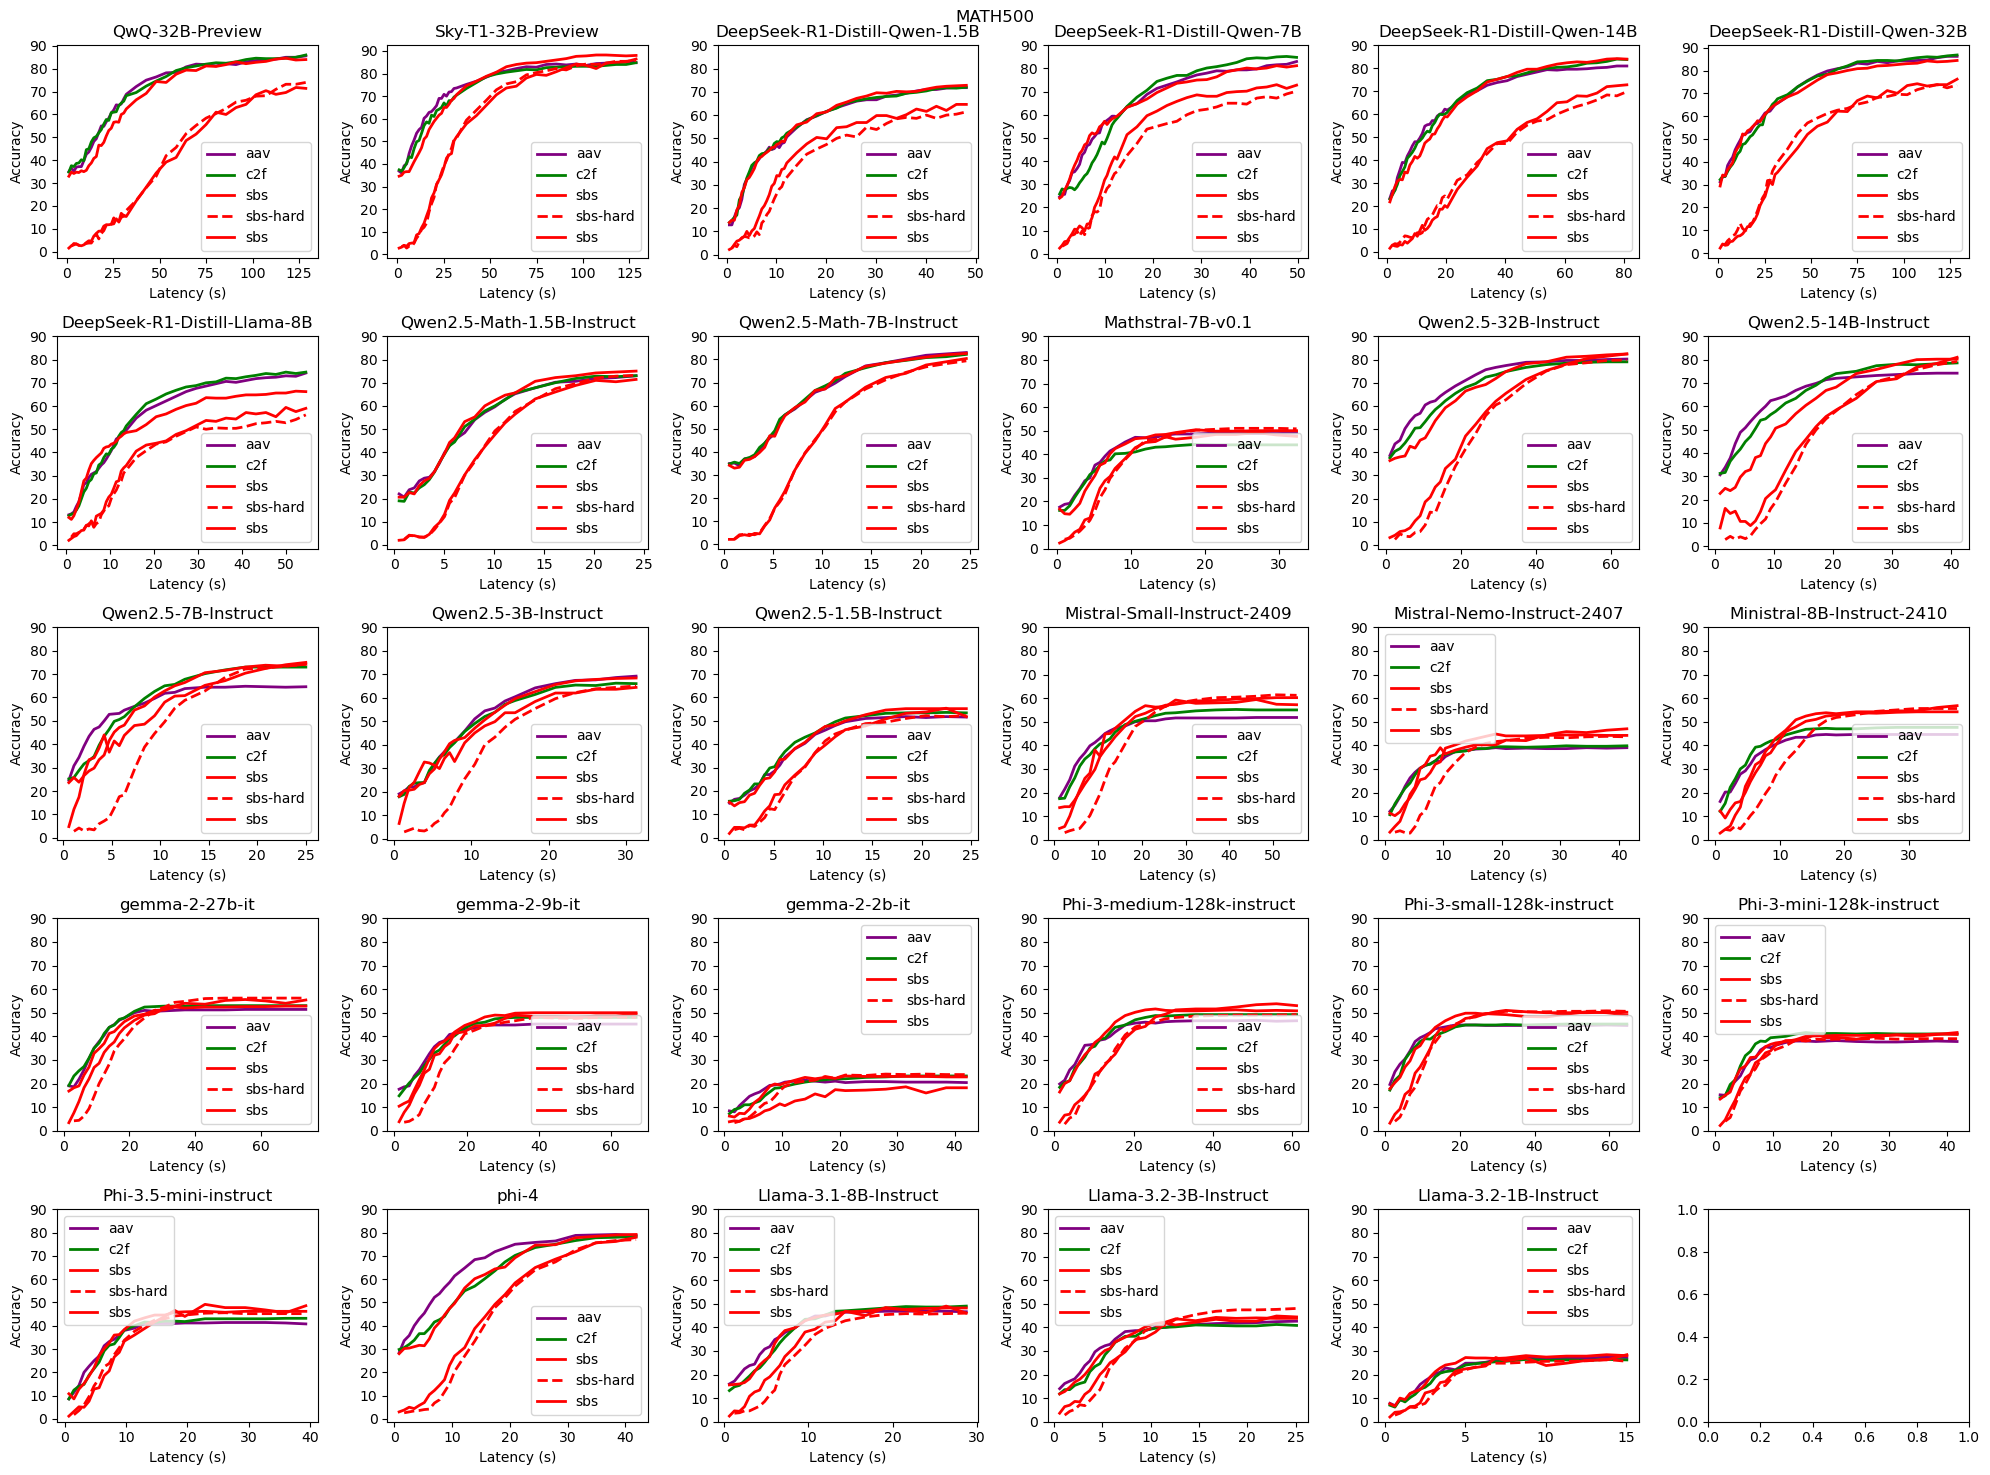

In [88]:
# Create a 2x3 subplot
fig, axs = plt.subplots(5, 6, figsize=(20, 15))
marker_size = 5  # Set the desired marker size
line_width = 2   # Set the desired line width

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot all lines first without labels
for index, model in enumerate(model_list):
    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        if "sbs-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="red", label="sbs-hard", linewidth=line_width)
        elif "direct-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="orange", label="direct-hard", linewidth=line_width)
        elif "quick-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="pink", label="quick-hard", linewidth=line_width)
        elif "c2f-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="green", label="c2f-hard", linewidth=line_width)
        elif "aav-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="purple", label="aav-hard", linewidth=line_width)
        elif "sbs" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="red", label="sbs", linewidth=line_width)
        elif "direct" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="orange", label="direct", linewidth=line_width)
        elif "quick" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="pink", label="quick", linewidth=line_width)
        elif "c2f" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="green", label="c2f", linewidth=line_width)
        # elif "kf" in prompt_type:
        #     axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="blue", label="kf", linewidth=line_width)
        elif "aav" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="purple", label="aav", linewidth=line_width)
        axs[index].set_xlabel("Latency (s)")
        axs[index].set_ylabel("Accuracy")
        axs[index].set_title(f"{model.split('/')[-1]}")
        axs[index].legend()
        
        # Set y-axis and x-axis ticks
        axs[index].set_yticks(range(0, 91, 10))  # Set y-axis interval to 10
        # axs[index].set_xticks(range(0, 551, 50))  # Set x-axis interval to 50

# set the title
plt.suptitle(f"{dataset}".upper())
# Adjust layout
plt.tight_layout()